In [1]:
import shutil

source_dir = "/kaggle/input/plantvillage-dataset/color/Potato___Early_blight"
destination_dir = "/kaggle/working/Potato___Early_blight"
shutil.copytree(source_dir, destination_dir)

source_dir = "/kaggle/input/plantvillage-dataset/color/Potato___Late_blight"
destination_dir = "/kaggle/working/Potato___Late_blight"
shutil.copytree(source_dir, destination_dir)

source_dir = "/kaggle/input/plantvillage-dataset/color/Potato___healthy"
destination_dir = "/kaggle/working/Potato___healthy"
shutil.copytree(source_dir, destination_dir)


'/kaggle/working/Potato___healthy'

In [2]:
import os

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
import tensorflow as tf
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras import models, layers
import keras
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.utils import to_categorical, plot_model


2024-05-31 17:35:37.490159: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-31 17:35:37.490258: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-31 17:35:37.621438: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
data_path = '/kaggle/working/'

In [4]:
def create_dataframe(data_path):
    filepaths = []
    labels = []

    for fold in os.listdir(data_path):
        f_path = os.path.join(data_path, fold)
        if os.path.isdir(f_path):
            imgs = os.listdir(f_path)
            for img in imgs:
                img_path = os.path.join(f_path, img)
                filepaths.append(img_path)
                labels.append(fold)

    fseries = pd.Series(filepaths, name='Filepaths')
    lseries = pd.Series(labels, name='Labels')
    return pd.concat([fseries, lseries], axis=1)

# Create DataFrame for the dataset
df = create_dataframe(data_path)

In [5]:
df

Filepaths                 Labels
0     /kaggle/working/Potato___Early_blight/20e451e3...  Potato___Early_blight
1     /kaggle/working/Potato___Early_blight/8c3d0f9e...  Potato___Early_blight
2     /kaggle/working/Potato___Early_blight/10a3920b...  Potato___Early_blight
3     /kaggle/working/Potato___Early_blight/838c8a0a...  Potato___Early_blight
4     /kaggle/working/Potato___Early_blight/8c1f94fb...  Potato___Early_blight
...                                                 ...                    ...
2147  /kaggle/working/Potato___healthy/ec6e43d3-512d...       Potato___healthy
2148  /kaggle/working/Potato___healthy/f66af6c0-6fc6...       Potato___healthy
2149  /kaggle/working/Potato___healthy/5ea316eb-10a2...       Potato___healthy
2150  /kaggle/working/Potato___healthy/22322780-95b4...       Potato___healthy
2151  /kaggle/working/Potato___healthy/a5050bde-febc...       Potato___healthy

[2152 rows x 2 columns]

In [6]:
# Step 1: Split into 70% training and 30% dummy
train_df, dummy_df = train_test_split(df, train_size=0.7, shuffle=True, random_state=42)

# Step 2: Split dummy_df into 20% testing and 10% validation
test_df, valid_df = train_test_split(dummy_df, train_size=2/3, shuffle=True, random_state=42)

In [7]:
print(train_df.shape)
print(dummy_df.shape)
print(valid_df.shape)
print(test_df.shape)

(1506, 2)
(646, 2)
(216, 2)
(430, 2)


In [8]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [9]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepaths',
    y_col='Labels',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=valid_df,
    x_col='Filepaths',
    y_col='Labels',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepaths',
    y_col='Labels',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 1506 validated image filenames belonging to 3 classes.
Found 216 validated image filenames belonging to 3 classes.
Found 430 validated image filenames belonging to 3 classes.


In [10]:
print(f'Training samples: {train_generator.samples}')
print(f'Validation samples: {valid_generator.samples}')
print(f'Test samples: {test_generator.samples}')

Training samples: 1506
Validation samples: 216
Test samples: 430


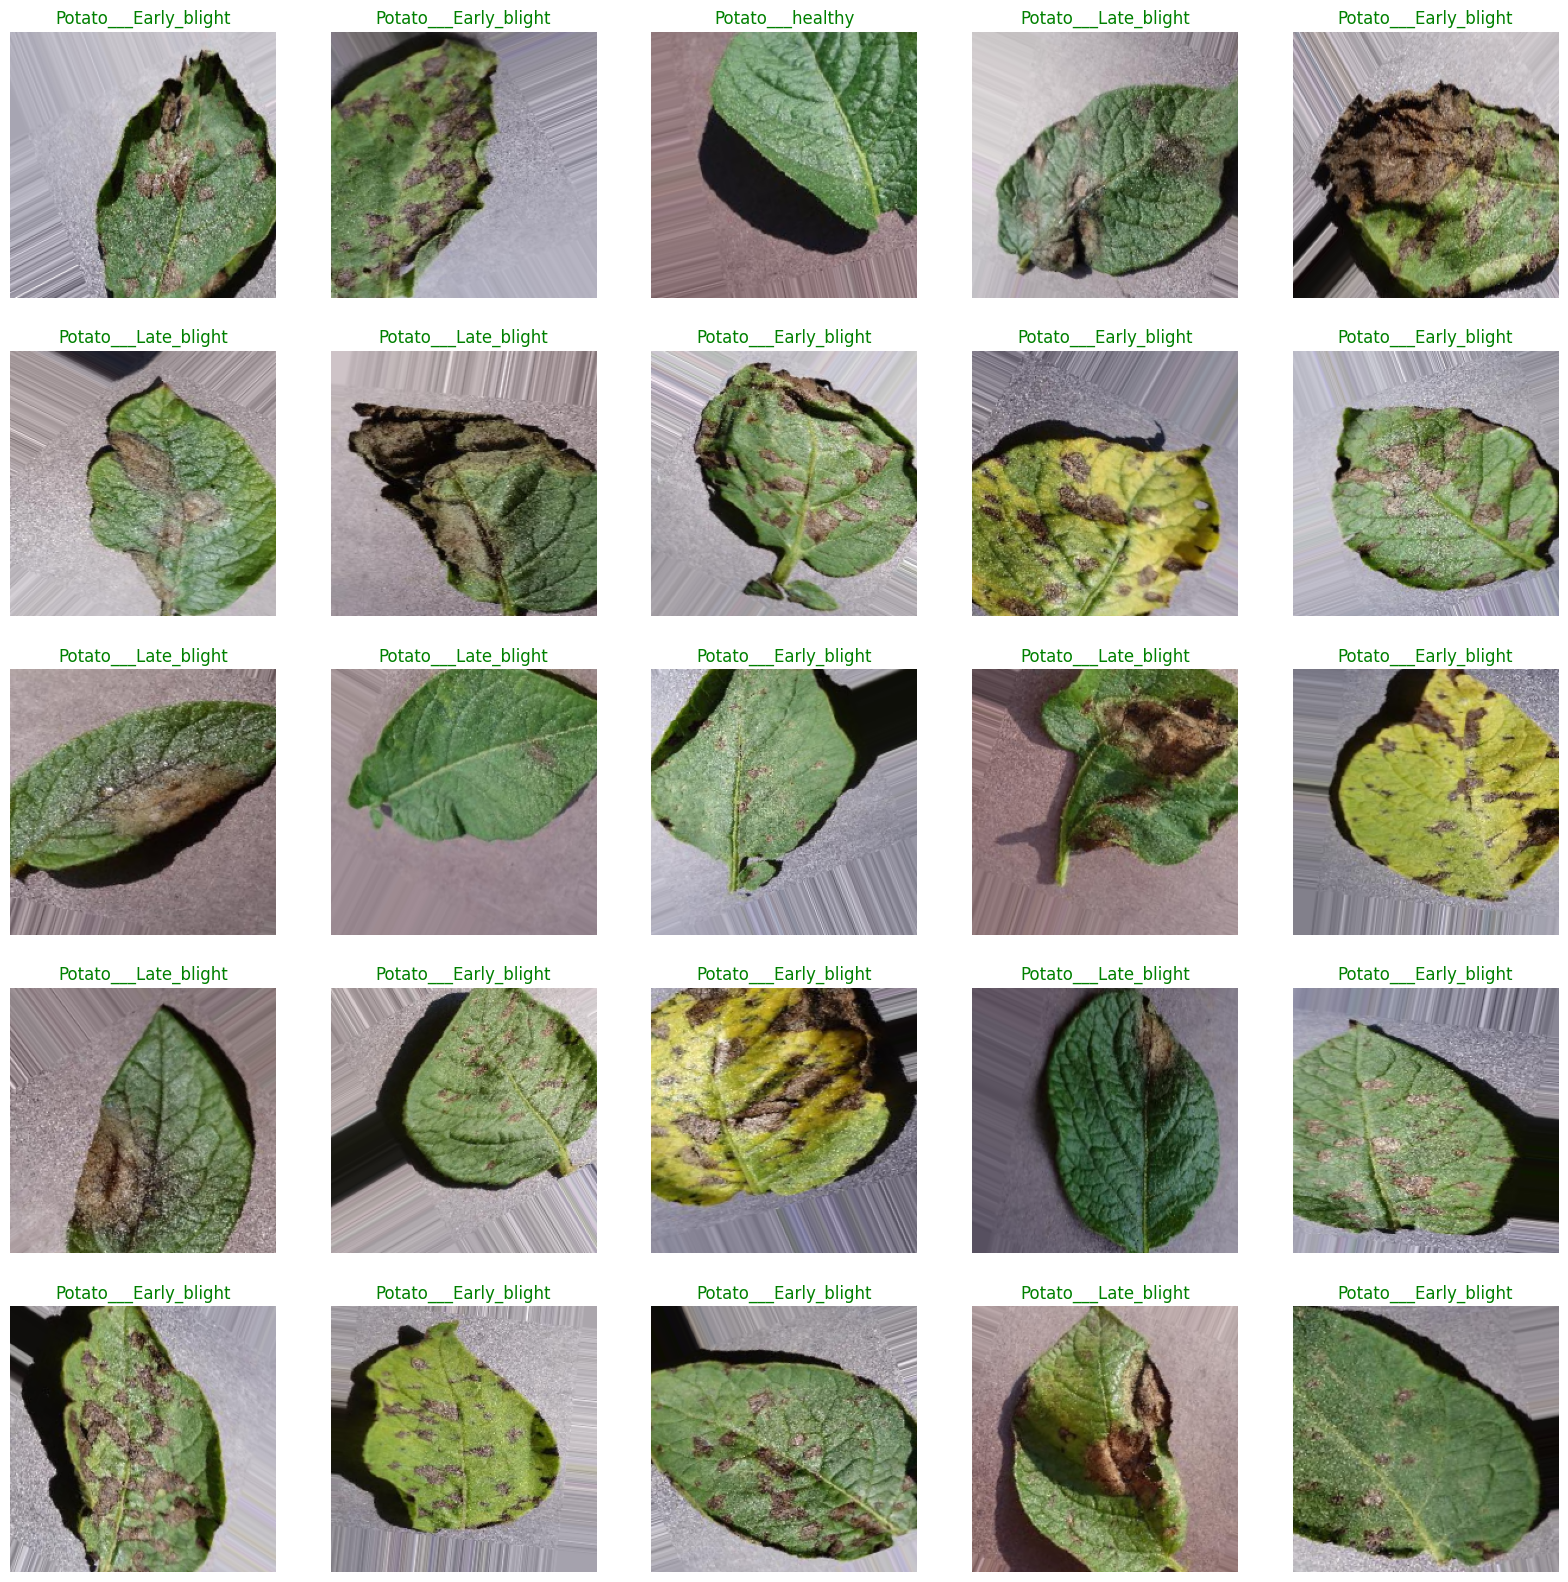

In [31]:
import matplotlib.pyplot as plt
import numpy as np

def show_images(image_gen):
    class_dict = image_gen.class_indices
    classes = list(class_dict.keys())
    
    images, labels = next(image_gen)
    
    plt.figure(figsize=(20, 20))
    
    num_images = min(len(labels), 25)
    
    for i in range(num_images):
        plt.subplot(5, 5, i + 1)
        
        image = images[i]
        
        plt.imshow(image)
        
        index = np.argmax(labels[i])
        class_name = classes[index]
        
        plt.title(class_name, color="green", fontsize=12)
        plt.axis('off')
    
    plt.show()

show_images(train_generator)

In [36]:

input_shape = (224, 224, 3)  
n_classes = len(train_generator.class_indices)

model = keras.Sequential([
    keras.layers.Conv2D(filters=64, kernel_size=(7, 7), strides=(3, 3), activation='relu', input_shape=input_shape),
    keras.layers.MaxPool2D(pool_size=(3, 3)),

    keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),

    keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),

    keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),

    keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),

    keras.layers.Flatten(),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(256, activation='relu'),

    keras.layers.Dense(n_classes, activation='softmax')
])


model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

model.summary()


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_35 (Conv2D)              │ (None, 73, 73, 64)     │         9,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 12, 12, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 6, 6, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 3, 3, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 625,667 (2.39 MB)

 Trainable params: 625,667 (2.39 MB)

 Non-trainable params: 0 (0.00 B)

In [37]:
history = model.fit(
    train_generator,
    batch_size=32,
    validation_data=valid_generator,
    epochs=50
)

Epoch 1/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 21s 322ms/step - accuracy: 0.4753 - loss: 0.9713 - val_accuracy: 0.6019 - val_loss: 0.8966
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 15s 275ms/step - accuracy: 0.5414 - loss: 0.9183 - val_accuracy: 0.5046 - val_loss: 0.8507
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 15s 269ms/step - accuracy: 0.5443 - loss: 0.8299 - val_accuracy: 0.7731 - val_loss: 0.5769
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 15s 273ms/step - accuracy: 0.7683 - loss: 0.5787 - val_accuracy: 0.7176 - val_loss: 0.7664
Epoch 5/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 15s 274ms/step - accuracy: 0.7539 - loss: 0.6074 - val_accuracy: 0.7917 - val_loss: 0.4831
Epoch 6/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 16s 274ms/step - accuracy: 0.8187 - loss: 0.4295 - val_accuracy: 0.8565 - val_loss: 0.3910
Epoch 7/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 15s 273ms/step - accuracy: 0.8226 - loss: 0.3799 - val_accuracy: 0.9259 - val_loss: 0.1744
Epoch 8/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 15s 274ms/step - accuracy: 0.8793 - loss: 0.2981 - val_accu

In [38]:
scores = model.evaluate(test_generator)
scores

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.9860 - loss: 0.1131


[0.5881096720695496, 0.9790697693824768]

In [39]:
test_generator.reset()
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step


In [40]:
true_classes = test_generator.classes

In [41]:
from sklearn.metrics import classification_report  

class_labels = list(test_generator.class_indices.keys())
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

                       precision    recall  f1-score   support

Potato___Early_blight       1.00      0.98      0.99       202
 Potato___Late_blight       0.98      0.97      0.98       199
     Potato___healthy       0.85      1.00      0.92        29

             accuracy                           0.98       430
            macro avg       0.94      0.99      0.96       430
         weighted avg       0.98      0.98      0.98       430



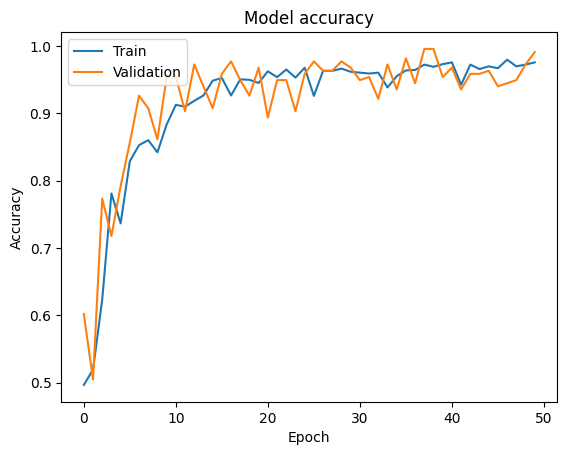

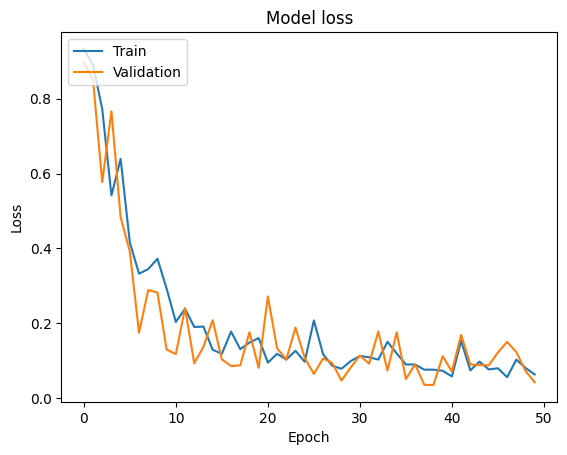

In [42]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [43]:
class_names = list(test_generator.class_indices.keys())

images_batch, labels_batch = next(test_generator)

first_image = images_batch[0]
first_label = np.argmax(labels_batch[0])  
batch_prediction = model.predict(images_batch)
predicted_label_index = np.argmax(batch_prediction[0])

print("Actual label:", class_names[first_label])
print("Predicted label:", class_names[predicted_label_index])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step
Actual label: Potato___Early_blight
Predicted label: Potato___Early_blight


In [44]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

for images_batch, labels_batch in test_generator:
    for i in range(min(len(images_batch), 9)):
        predicted_class, confidence = predict(model, images_batch[i])
        actual_class = class_names[np.argmax(labels_batch[i])] 
        
        print(f"Actual: {actual_class}, Predicted: {predicted_class}, Confidence: {confidence}%")
        
    break 


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 606ms/step
Actual: Potato___Early_blight, Predicted: Potato___Early_blight, Confidence: 100.0%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Actual: Potato___healthy, Predicted: Potato___healthy, Confidence: 99.89%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Actual: Potato___Early_blight, Predicted: Potato___Early_blight, Confidence: 100.0%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Actual: Potato___healthy, Predicted: Potato___healthy, Confidence: 99.99%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Actual: Potato___Early_blight, Predicted: Potato___Early_blight, Confidence: 89.24%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Actual: Potato___Late_blight, Predicted: Potato___Late_blight, Confidence: 100.0%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Actual: Potato___Early_blight, Predicted: Potato___Early_blight, Confidence: 100.0%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Actual: Potato___healthy, Predicted: Potato___healthy, Confidence: 100.0%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Actual: Potato___

In [45]:
model.save("Model_P_v5.h5")